In [5]:
import torch
import torch_geometric
import torch.nn as nn
import networks
import datasetLoader
import evaluation
import importlib
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
import networkx as nx
from typing import Literal
import random

importlib.reload(datasetLoader)
importlib.reload(networks)
importlib.reload(evaluation)

<module 'evaluation' from 'c:\\Users\\trist\\Git_repos\\BT-ML-PGESAT\\code\\PGExplainer\\evaluation.py'>

In [6]:
batch_size = 1                 # 64 used for Graphs in PGE (PGExplainer/codes/forgraph/config.py)      1 takes forever in current model

learning_rate_gnn = 0.001        #0.001 on ADAM
epochs_gnn = 1000
early_stopping = 500

loss = nn.CrossEntropyLoss()           # cross entropy loss?!

datasetName: Literal['BA-Shapes', 'BA-Community', 'Tree-Cycles', 'TreeGrid'] = 'BA-Shapes'

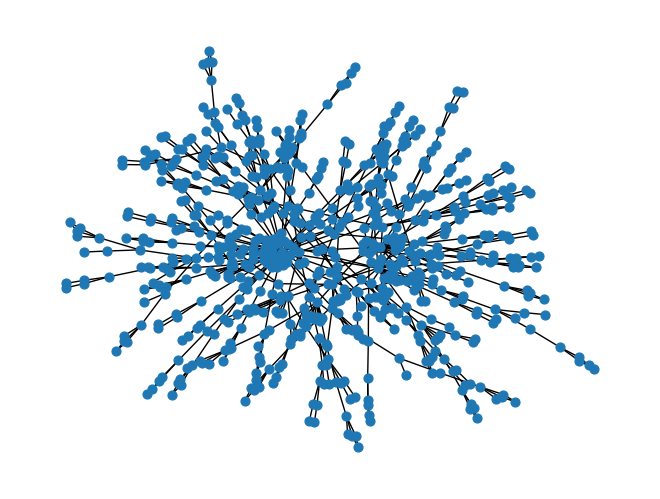

In [3]:
dataset = datasetLoader.loadNodeDataset(datasetName)

g = torch_geometric.utils.to_networkx(dataset[0], to_undirected=True)
nx.draw(g, node_size=40,font_size=8)

trainLoader = DataLoader(dataset, 1, True)

In [87]:
print(dataset[0].edge_index)

tensor([[  0,   0,   0,  ..., 699, 205, 698],
        [  4,  18,  51,  ..., 696, 698, 205]])


In [7]:
gnn = networks.GraphGNN(features = 1, labels=4)       # temp.y.shape[0] is wrong!!! TODO: how do I get #labels from loader?? take from loader.dataset? Store with dataset

# Applies xavier to nn.Linear. GraphConv weight init done in network
#gnn.apply(weights_init)

gnn_optimizer = torch.optim.Adam(params = gnn.parameters(), lr = learning_rate_gnn)         # TODO: understand params

print(f"Training on {len(dataset)} graphs with batch size {batch_size}")

early_stop_counter = 0
min_val_loss = 1000.0
best_val_acc = 0
best_epoch = 0

train_losses = []

train_accuracies = []

for epoch in range(0, epochs_gnn) :
    print(f'\n------------------ EPOCH {epoch + 1} -------------------')

    gnn.train()

    train_acc_sum = 0
    num_batches = 1.0
    train_loss = 0.0

    #batch_size_ratio = len(data)/batch_size
    #num_batches += batch_size_ratio
    
    r = list(range(len(dataset[0].y)))
    random.shuffle(r)

    for i in r:
        
        gnn_optimizer.zero_grad()       # Reset parameters

        # get model embeddings (node representations)?
        out = gnn.forward(dataset[0].x, dataset.edge_index)

        #print(out)

        # calc cross entropy(???)loss between real label and predicted label
        # needs to be calculated across batch
        currLoss = loss(out, dataset[0].y[i].unsqueeze(0))

        # loss backward
        currLoss.backward()
        
        torch.nn.utils.clip_grad_norm_(gnn.parameters(), max_norm=2)    # clip gradient above 2(for ba2motfis according to reimplementation) to stop "overlearning"?

        # optimizer step
        gnn_optimizer.step()

        # predicted labels
        preds = out.argmax(dim=1)
        train_acc_sum += torch.sum(preds == dataset[0].y[i])                         # DONE: works with batches?
        
        train_loss +=  currLoss.item()                    # use currLoss.item() instead of currLoss for numeric value



    final_train_acc = train_acc_sum/700                # num_batches*batch_size = len(train_loader.dataset) = #graphs

    gnn.eval()

    # avg loss
    print(f"average training loss: {train_loss/700}, training acc: {final_train_acc}")

    train_losses.append(train_loss/700)
    train_accuracies.append(final_train_acc)

Training on 1 graphs with batch size 1

------------------ EPOCH 1 -------------------
average training loss: 16.32724594901134, training acc: 0.3271428644657135

------------------ EPOCH 2 -------------------
average training loss: 2.1371708444506097, training acc: 0.41285714507102966

------------------ EPOCH 3 -------------------
average training loss: 1.7202694748602299, training acc: 0.427142858505249

------------------ EPOCH 4 -------------------
average training loss: 1.667164780338561, training acc: 0.4228571355342865

------------------ EPOCH 5 -------------------
average training loss: 1.6326417697545341, training acc: 0.427142858505249

------------------ EPOCH 6 -------------------
average training loss: 1.5632647950094907, training acc: 0.4300000071525574

------------------ EPOCH 7 -------------------
average training loss: 1.4963661947234401, training acc: 0.4285714328289032

------------------ EPOCH 8 -------------------
average training loss: 1.5918875460734854, train

: 